## Problem 1-1

In [1]:
# initialize
library(igraph)
library(ggplot2)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



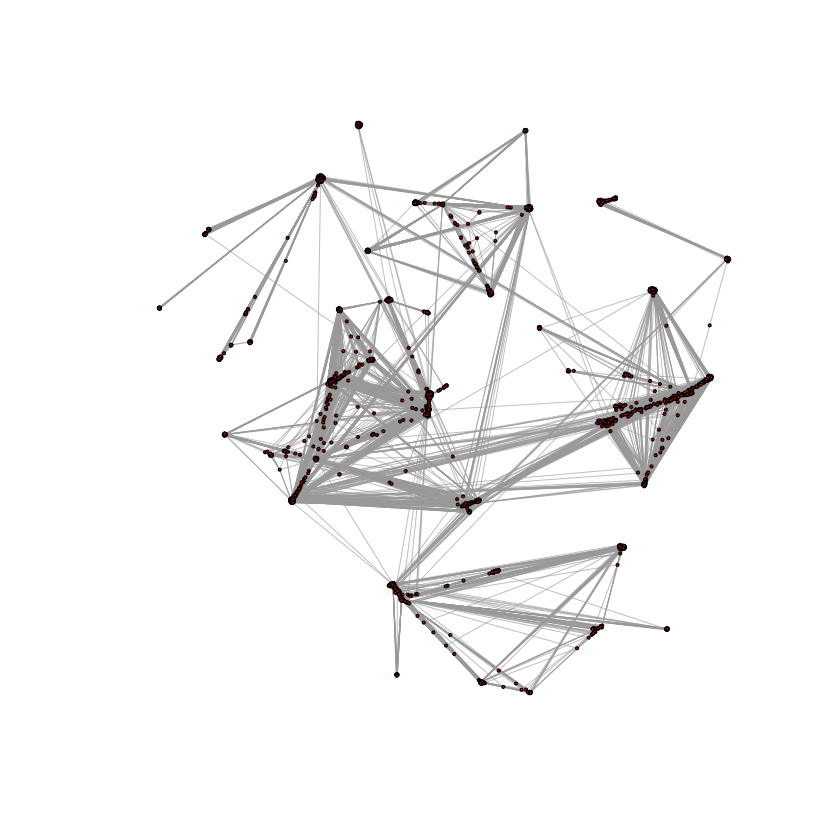

In [2]:
edge_list <- read.table("./facebook_combined.txt");
node_list1 <- names(table(edge_list$V1));
node_list2 <- names(table(edge_list$V2));
node_list <- union(node_list1, node_list2);

net <- graph_from_data_frame(d=edge_list, vertices=node_list, directed=FALSE) 
plot(net,vertex.size=1,vertex.label=NA, vertex.color="red",
     edge.width=0.5,edge.arrow.size=0.1);

### Question 1

In [3]:
is.connected(net);

[1] TRUE

### Question 2

In [4]:
d<-diameter(net, directed = FALSE, unconnected =FALSE);
print(d);

[1] 8


### Question 3

In [5]:
net_degrees <- degree(net);
net_degrees_hist <- as.data.frame(table(net_degrees));

net_degrees_hist[,1] <- as.numeric(net_degrees_hist[,1]);

In [6]:
# change to probablity
net_degrees_hist[,2]  <- net_degrees_hist[,2] / sum(net_degrees_hist$Freq);

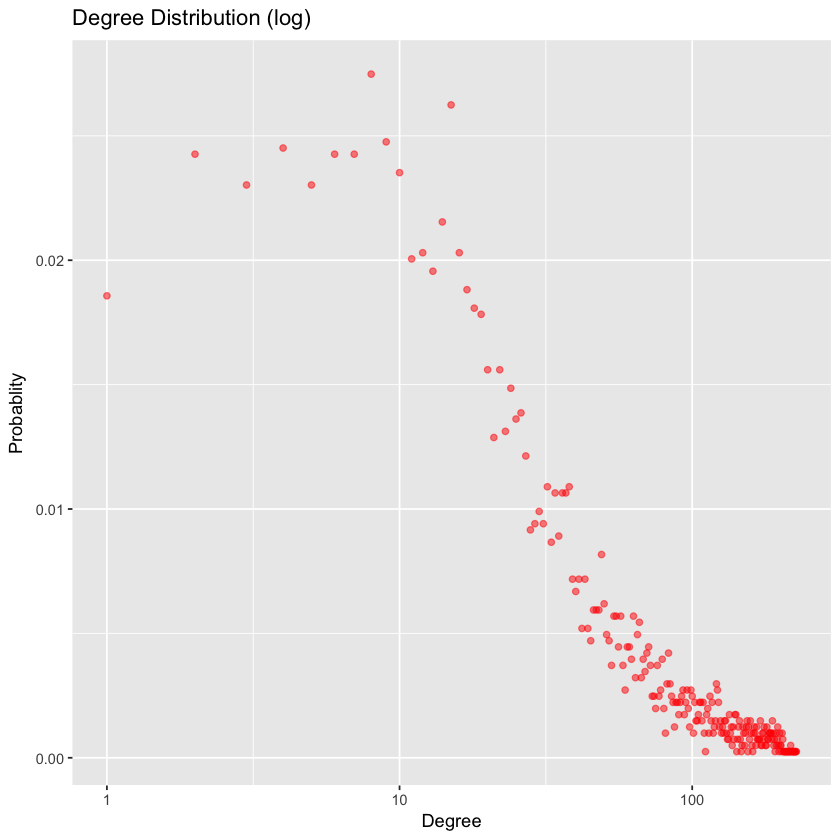

In [7]:
# plot
p <- ggplot(net_degrees_hist, aes(x = net_degrees, y = Freq)) + geom_point(alpha=0.5, color="red");
#p <- p + geom_smooth(method = "lm")
p <- p + scale_x_continuous("Degree",
                            breaks = c(1, 10, 100, 1000,2000),
                            trans = "log10");
p <- p + labs(y = "Probablity")
p <-  p + ggtitle("Degree Distribution (log)")
p

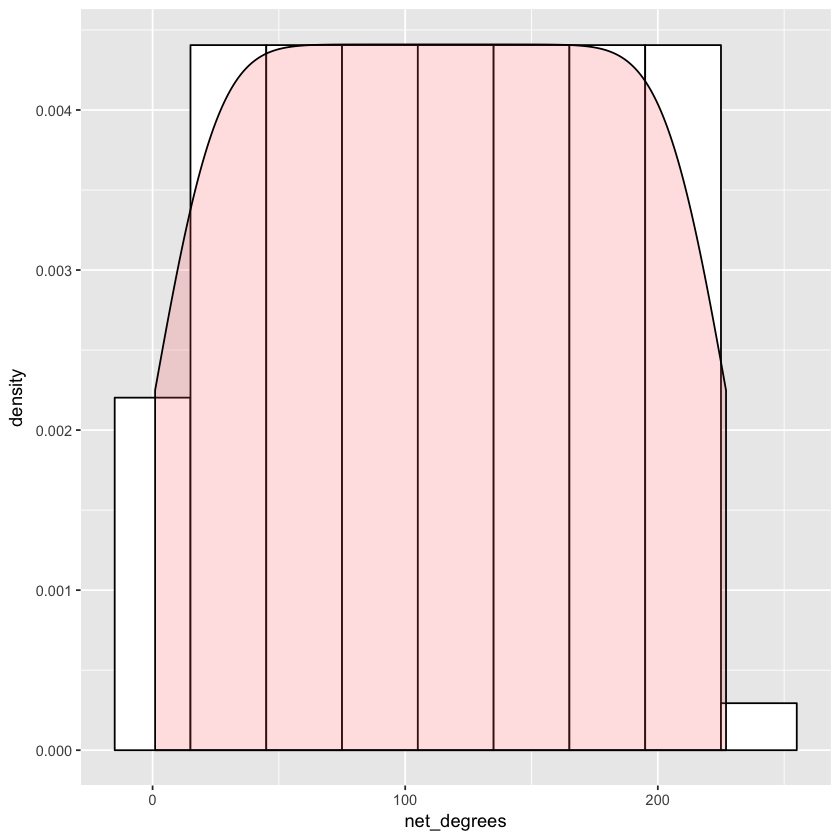

In [8]:
# histogram
p <- ggplot(net_degrees_hist, aes(x=net_degrees));
p <- p + geom_histogram(aes(y=..density..),color="black", fill="white", binwidth = 30);
p <- p + geom_density(alpha=.2, fill="#FF6666");
p

### Question 4

In [9]:
getAlpha<-function(g,xmin){
  d <- degree(g);
  fit <- fit_power_law(d,xmin=xmin);
  return(fit$alpha);
}

slope <- -getAlpha(net ,10);
print(paste("slope is", slope))

[1] "slope is -1.72349073613742"


### Question 5

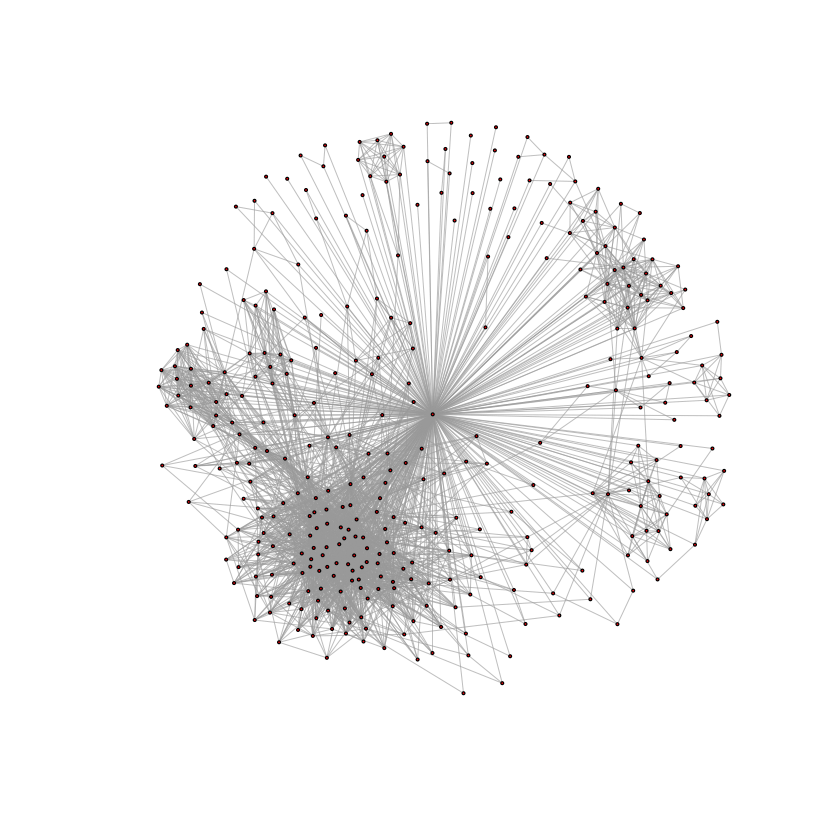

In [10]:
sub_edge_list <- edge_list[edge_list$V1 == 0,];
sub_node_list1 <- names(table(sub_edge_list$V1));
sub_node_list2 <- names(table(sub_edge_list$V2));
sub_node_list <- union(sub_node_list1, sub_node_list2);

# gengerate induced graph
sub_net <- induced_subgraph(net, sub_node_list);

plot(sub_net,vertex.size=1,vertex.label=NA, vertex.color="red",
     edge.width=0.5,edge.arrow.size=0.1);

In [11]:
# number of nodes
print(paste("number of nodes = ",length(sub_node_list)));

[1] "number of nodes =  348"


In [12]:
# number of edges
print(paste("number of edges = ", gsize(sub_net)));

[1] "number of edges =  2866"


### Question 6

In [13]:
diam <- diameter(sub_net);
print(paste("diameter of the sub-network = ",diam));

[1] "diameter of the sub-network =  2"


# Problem 1-3

### Question 8

In [14]:
neighbor_count <- c();
node_list <- as.integer(node_list);
for(v in node_list){
  neighbor_count <- append(neighbor_count,length(neighbors(net, v+1, mode = "total")));
}

# number of nodes who have > 200 neighbors
cr_number <- length(neighbor_count[neighbor_count > 200]);
print(paste("number of core nodes = ", cr_number));
# average number of neighbors
print(paste("average number of core neighbors = ", mean(neighbor_count[neighbor_count > 200])));

[1] "number of core nodes =  40"
[1] "average number of core neighbors =  279.375"


### Question 10

In [9]:
# extract peronalized network
person_net <- function(net, vertex, edge_list){
  sub_edge_list_v1 <- edge_list[edge_list$V1 == vertex,];
  sub_edge_list_v2 <- edge_list[edge_list$V2 == vertex,];
  
  sub_node_list1 <- names(table(sub_edge_list_v1$V2));
  sub_node_list2 <- names(table(sub_edge_list_v2$V1));
  
  # add core node
  sub_node_list2 <- append(sub_node_list2, vertex)
  sub_node_list <- union(sub_node_list1, sub_node_list2);
  
  sub_edge_1 <- edge_list[edge_list$V1 %in% sub_node_list, ];
  sub_edge_2 <- sub_edge_1[sub_edge_1$V2 %in% sub_node_list, ];
  sum_edge_uq <- unique(sub_edge_2);
  ind_graph <- graph_from_data_frame(d=sum_edge_uq, vertices=sub_node_list, directed=FALSE) ;
  return(ind_graph);
}

In [6]:
# parse parameters
parse_para <- function(net, vertex, edge_list){
  ind_net <- person_net(net, vertex, edge_list);
  
  # fast greedy
  com_greedy <- cluster_fast_greedy(ind_net);
  greedy_mod <- modularity(ind_net,com_greedy$membership);
  
  jpeg(paste("fast_greedy_",vertex,".jpg"))
  plot(com_greedy,ind_net,vertex.size=2,vertex.label=NA);
  dev.off()
  
  # edge betweenness
  com_eb <- cluster_edge_betweenness(ind_net, directed=FALSE);
  eb_mod <- modularity(ind_net,com_eb$membership);
  
  jpeg(paste("edge_betweenness_",vertex,".jpg"));
  plot(com_eb,ind_net,vertex.size=2,vertex.label=NA);
  dev.off();
  
  # Infomap
  com_if_mp <- cluster_infomap(ind_net, modularity = TRUE);
  if_map_mod <- modularity(ind_net,com_if_mp$membership);
  
  jpeg(paste("info_map_",vertex,".jpg"));
  plot(com_if_mp,ind_net,vertex.size=2,vertex.label=NA);
  dev.off();
  
  # return modularity
  para_tmp <- c(vertex, greedy_mod, eb_mod, if_map_mod);
  return(para_tmp)
}

In [17]:
vertex_list <- c(0, 108, 349, 484, 1087);
para_matrix <- rep(0,4);
for (vertex in vertex_list){
  para_tmp <- parse_para(net, vertex, edge_list);
  para_matrix <- rbind(para_matrix, para_tmp);
}
para_matrix <- para_matrix[2:6,];
print(para_matrix)

         [,1]        [,2]      [,3]       [,4]
para_tmp    0  0.41310137 0.3533022 0.39412544
para_tmp  108  0.01991111 0.0000000 0.00000000
para_tmp  349 -0.04081633 0.0000000 0.00000000
para_tmp  484  0.29477373 0.1281372 0.04521351
para_tmp 1087  0.04432133 0.0000000 0.00000000


### Question 9

In [5]:


person_net_rm <- function(net, vertex, edge_list){
  sub_edge_list_v1 <- edge_list[edge_list$V1 == vertex,];
  sub_edge_list_v2 <- edge_list[edge_list$V2 == vertex,];
  
  sub_node_list1 <- names(table(sub_edge_list_v1$V2));
  sub_node_list2 <- names(table(sub_edge_list_v2$V1));
  
  # do not include core node
  sub_node_list <- union(sub_node_list1, sub_node_list2);
  
  sub_edge_1 <- edge_list[edge_list$V1 %in% sub_node_list, ];
  sub_edge_2 <- sub_edge_1[sub_edge_1$V2 %in% sub_node_list, ];
  
  sum_edge_uq <- unique(sub_edge_2);
  
  ind_graph_rm <- graph_from_data_frame(d=sum_edge_uq, vertices=sub_node_list, directed=FALSE) ;
  return(ind_graph_rm);
}



In [4]:
# parse parameters
parse_para_rm <- function(net, vertex, edge_list){
  ind_graph_rm <- person_net_rm(net, vertex, edge_list);
  
  # fast greedy
  com_greedy <- cluster_fast_greedy(ind_graph_rm);
  greedy_mod <- modularity(ind_graph_rm,com_greedy$membership);
  
  jpeg(paste("fast_greedy_rm_",vertex,".jpg"))
  plot(com_greedy,ind_graph_rm,vertex.size=2,vertex.label=NA);
  dev.off()
  
  # edge betweenness
  com_eb <- cluster_edge_betweenness(ind_graph_rm, directed=FALSE);
  eb_mod <- modularity(ind_graph_rm,com_eb$membership);
  
  jpeg(paste("edge_betweenness_rm_",vertex,".jpg"));
  plot(com_eb,ind_graph_rm,vertex.size=2,vertex.label=NA);
  dev.off();
  
  # Infomap
  com_if_mp <- cluster_infomap(ind_graph_rm, modularity = TRUE);
  if_map_mod <- modularity(ind_graph_rm,com_if_mp$membership);
  
  jpeg(paste("info_map_rm_",vertex,".jpg"));
  plot(com_if_mp,ind_graph_rm,vertex.size=2,vertex.label=NA);
  dev.off();
  
  # return modularity
  para_tmp <- c(vertex, greedy_mod, eb_mod, if_map_mod);
  return(para_tmp)
}

In [20]:
vertex_list <- c(0, 108, 349, 484, 1087);
para_matrix_rm <- rep(0,4);
for (vertex in vertex_list){
  para_tmp <- parse_para_rm(net, vertex, edge_list);
  para_matrix_rm <- rbind(para_matrix_rm, para_tmp);
}
para_matrix_rm <- para_matrix_rm[2:6,];
print(para_matrix_rm)

         [,1]        [,2]      [,3]       [,4]
para_tmp    0  0.44185327 0.4161461 0.41800766
para_tmp  108  0.02588450 0.0000000 0.00000000
para_tmp  349 -0.05555556 0.0000000 0.00000000
para_tmp  484  0.31412846 0.2455849 0.06509536
para_tmp 1087  0.07986111 0.0000000 0.00000000


### Q12

In [3]:
# find embeddedness and dispersion
find_embeddedness_dispersion <- function(net, vertex ,edge_list){

    personalnetwork <- person_net_rm(net, vertex ,edge_list);
    embeddedness <- c();
    dispersion <- c();
    for ( subvertex in V(personalnetwork)){
        subvertex_name <- V(personalnetwork)[subvertex];
        mutual_friends <- neighbors(personalnetwork, subvertex);
        # find embeddedness
        embeddedness <- append(embeddedness, length(mutual_friends));
        # find dispersion
        tmp <- c(subvertex_name,mutual_friends);
        dia <- diameter(induced_subgraph(personalnetwork,tmp));
        tmp_graph1 <- induced_subgraph(personalnetwork,mutual_friends)
        vertex_dis <- sum(distances(tmp_graph1))/2
        if (vertex_dis == "Inf" ){
            vertex_dis = dia+2
        }
        dispersion <- append(dispersion, vertex_dis)
    }
    
    #Plot embeddedness
    embeddedness_hist <- as.data.frame(table(embeddedness));
    embeddedness_hist[,1] <- as.numeric(embeddedness_hist[,1]);
    embeddedness_hist[,2]  <- embeddedness_hist[,2] / sum(embeddedness_hist$Freq);
    jpeg("embeddedness distribution ",vertex,".jpg");
    plot(embeddedness_hist, paste0(main="Embeddedness ",vertex) );
    dev.off();
    #Plot dispersion

    dispersion_hist <- as.data.frame(table(dispersion));
    dispersion_hist[,1] <- as.numeric(dispersion_hist[,1]);
    dispersion_hist[,2]  <- dispersion_hist[,2] / sum(dispersion_hist$Freq);
    jpeg("dispersion distribution ",vertex,".jpg");
    plot(dispersion_hist, paste0( main="Dispersion ",vertex) );
    dev.off();
}

In [68]:
vertex_list <- c(0, 107, 348, 483, 1086);
for (vertex in vertex_list){
    find_embeddedness_dispersion (net, vertex, edge_list);

}

ERROR: Error in switch(units, `in` = res, cm = res/2.54, mm = res/25.4, px = 1) * : non-numeric argument to binary operator


### Question 13

In [23]:
find_max_dispersion <- function(net, vertex ,edge_list){
    personalnetwork <- person_net(net, vertex ,edge_list);
    personalnetwork_rm <- person_net_rm(net, vertex ,edge_list);
    maxsubvertex = 0;
    maxdispersion = 0;
    subvertex_name <- 0;
    for ( subvertex in V(personalnetwork_rm)){
        subvertex_name <- V(personalnetwork_rm)[subvertex];
        mutual_friends <- neighbors(personalnetwork_rm, subvertex_name);
        tmp <- c(subvertex_name,mutual_friends);
        dia <- diameter(induced_subgraph(personalnetwork_rm,tmp));
        # find dispersion 
        tmp_graph1 <- induced_subgraph(personalnetwork_rm,mutual_friends)
        vertex_dis <- sum(distances(tmp_graph1))/2
        if (vertex_dis == "Inf" ){
            vertex_dis = dia+2
        }
        if (vertex_dis>maxdispersion){
            maxdispersion <- vertex_dis;
            maxsubvertex <- subvertex_name;
        }
    }
     print(maxsubvertex);
}

In [24]:
vertex_list <- c(0, 107, 348, 483, 1086);
for (vertex in vertex_list){
    find_max_dispersion (net, vertex, edge_list);
}

+ 1/347 vertex, named, from cd6f855:
[1] 56
+ 1/1045 vertex, named, from fa78faf:
[1] 1888
+ 1/229 vertex, named, from d4f8685:
[1] 376
+ 1/231 vertex, named, from 5fb9891:
[1] 107
+ 1/205 vertex, named, from 255275e:
[1] 107


In [9]:
plot_max <- function(net, vertex_id ,edge_list,max_id){
    personalnetwork <- person_net(net, vertex_id ,edge_list);
    com_greedy <- cluster_fast_greedy(personalnetwork);
    colors <- rainbow(max(membership(com_greedy)))
    v <- c();
    for ( subvertex in V(personalnetwork)){
        subvertex_name <- V(personalnetwork)[subvertex]
        v <- c(v,subvertex_name)
    }
    v<-names(v);
    v_size <- setNames(c(rep(2,each = vcount(personalnetwork))),v);
    v_size[max_id] <- 15;
    E(personalnetwork)$color<-"grey";
    E(personalnetwork)$weight<-0.1;
    E(personalnetwork)[from(max_id)]$color<-"yellow";
    E(personalnetwork)[to(max_id)]$color<-"yellow";
    E(personalnetwork)[from(max_id)]$weight<-1;
    E(personalnetwork)[to(max_id)]$weight<-1;
    greedy_mod <- modularity(personalnetwork,com_greedy$membership);
    plot(personalnetwork,edge.width=E(personalnetwork)$weight,vertex.color=colors[membership(com_greedy)],vertex.size=v_size,vertex.label=NA);
}

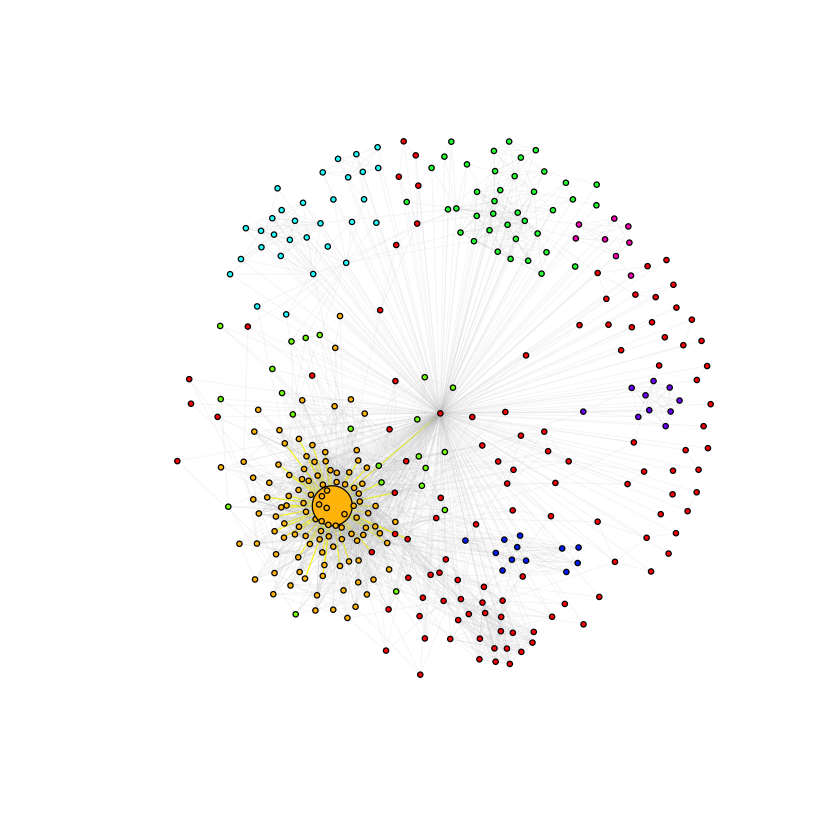

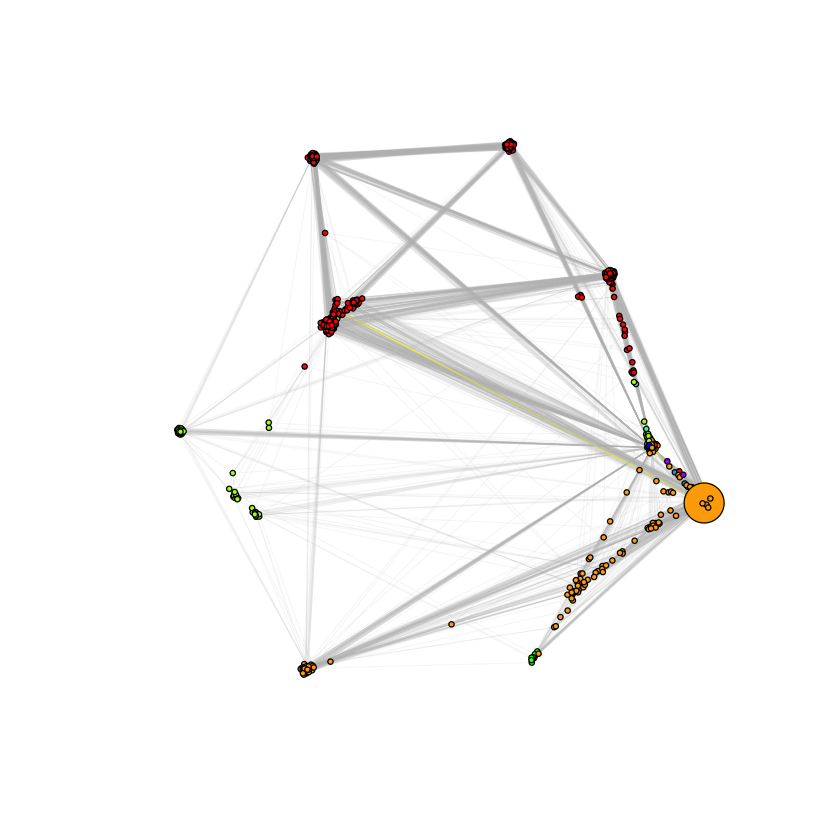

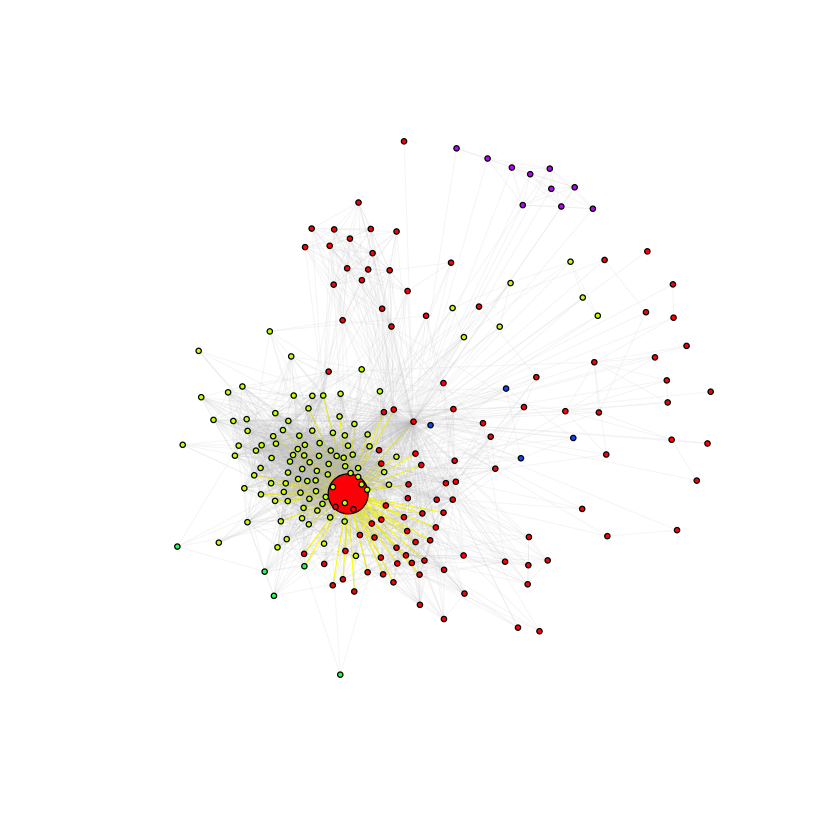

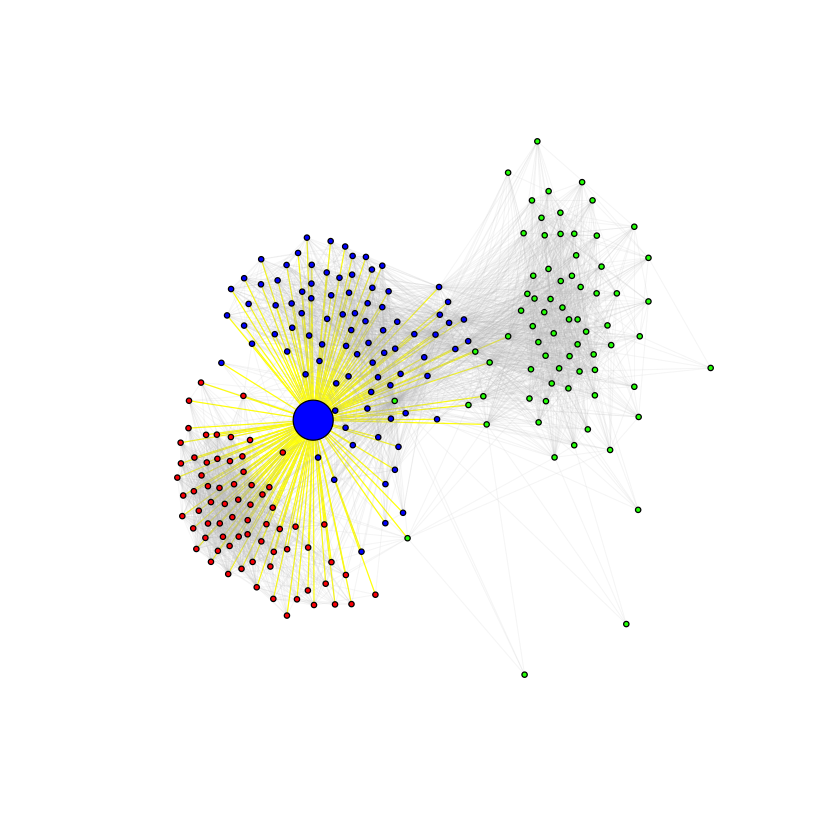

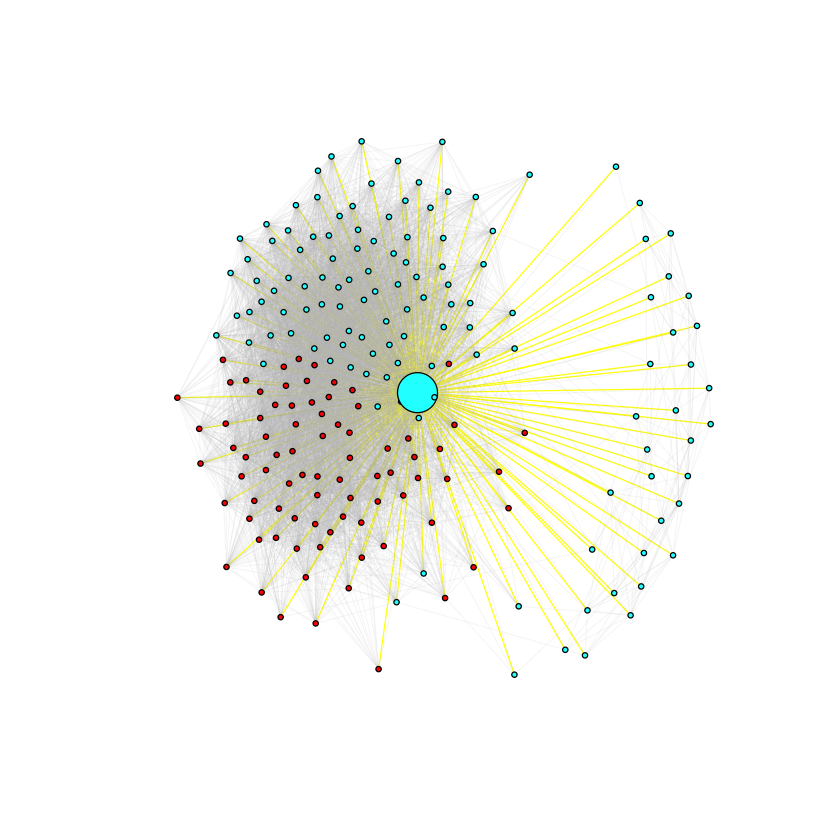

In [10]:
plot_max(net,0,edge_list,'56');
plot_max(net,107,edge_list,'1888');
plot_max(net,348,edge_list,'376');
plot_max(net,483,edge_list,'107');
plot_max(net,1086,edge_list,'107');


### Question 14

In [15]:
find_max_dispersionover_over_embeddedness <- function(net, vertex ,edge_list){
    personalnetwork <- person_net(net, vertex ,edge_list);
    personalnetwork_rm <- person_net_rm(net, vertex ,edge_list);
    maxsubvertex = 0;
    maxdispersion_over_embeddedness = 0;
    subvertex_name <- 0;

    for ( subvertex in V(personalnetwork_rm)){
        subvertex_name <- V(personalnetwork_rm)[subvertex];
        mutual_friends <- neighbors(personalnetwork_rm, subvertex);
        vertex_embeddedness <- length(mutual_friends)
        tmp <- c(subvertex_name,mutual_friends);
        dia <- diameter(induced_subgraph(personalnetwork_rm,tmp));
        # find dispersion 
        tmp_graph1 <- induced_subgraph(personalnetwork_rm,mutual_friends)
        vertex_dis <- sum(distances(tmp_graph1))/2
        if (vertex_dis == "Inf" ){
            vertex_dis = dia+2
        }
        if(vertex_embeddedness!=0 && vertex_embeddedness!=1 ){
            dispersion_over_embeddedness <- vertex_dis/vertex_embeddedness;
if (dispersion_over_embeddedness>maxdispersion_over_embeddedness){
            maxdispersion_over_embeddedness <- dispersion_over_embeddedness;
            maxsubvertex <- subvertex_name;
        }
        }
        
    }
     print(maxsubvertex);
}

In [16]:
vertex_list <- c(0, 107, 348, 483, 1086);
for (vertex in vertex_list){
    find_max_dispersionover_over_embeddedness (net, vertex, edge_list);
}

+ 1/347 vertex, named, from f0d6e7b:
[1] 322
+ 1/1045 vertex, named, from 594afb3:
[1] 1888
+ 1/229 vertex, named, from 6bf5bf3:
[1] 376
+ 1/231 vertex, named, from 241f1df:
[1] 107
+ 1/205 vertex, named, from 273d518:
[1] 107


In [10]:
find_max_embeddedness <- function(net, vertex ,edge_list){
    personalnetwork <- person_net(net, vertex ,edge_list);
    personalnetwork_rm <- person_net_rm(net, vertex ,edge_list);
    maxsubvertex = 0;
    maxembeddedness = 0;
    subvertex_name <- 0;

    for ( subvertex in V(personalnetwork_rm)){
        subvertex_name <- V(personalnetwork_rm)[subvertex];
        mutual_friends <- neighbors(personalnetwork_rm, subvertex);
        vertex_embeddedness <- length(mutual_friends)

        if (vertex_embeddedness>maxembeddedness){
            maxembeddedness <- vertex_embeddedness;
            maxsubvertex <- subvertex_name;
        }
    }
    print(maxsubvertex);
}

In [30]:
vertex_list <- c(0, 107, 348, 483, 1086);
for (vertex in vertex_list){
    find_max_embeddedness (net, vertex, edge_list);
}

+ 1/347 vertex, named, from 8b223e0:
[1] 56
+ 1/1045 vertex, named, from 7e513c9:
[1] 1888
+ 1/229 vertex, named, from b416faa:
[1] 376
+ 1/231 vertex, named, from 5b11998:
[1] 107
+ 1/205 vertex, named, from bb4a693:
[1] 107


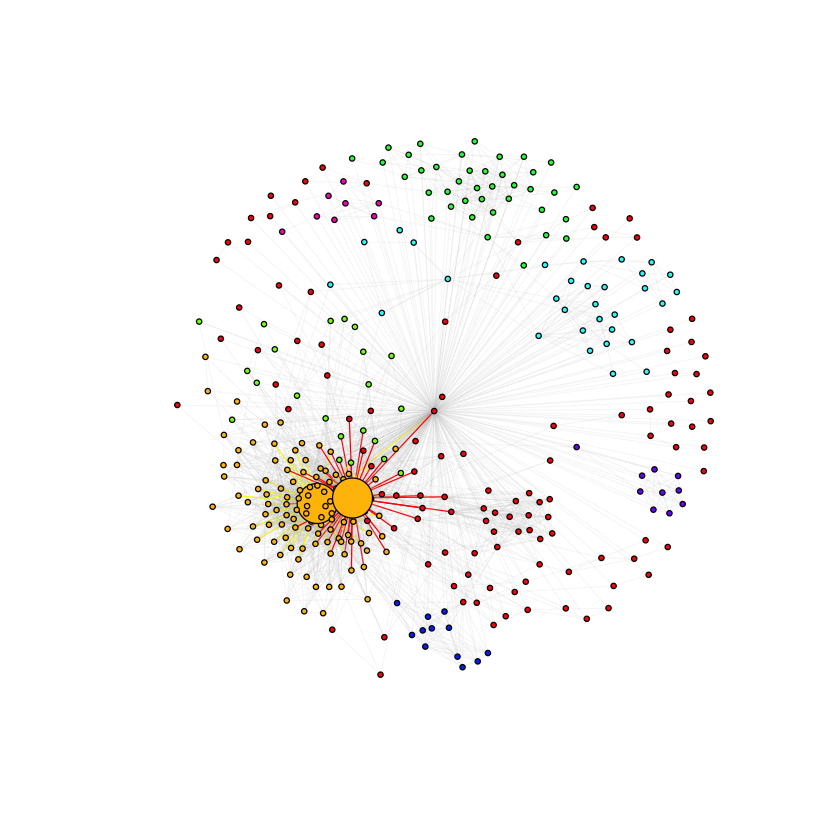

In [13]:
personalnetwork <- person_net(net, 0 ,edge_list);
    com_greedy <- cluster_fast_greedy(personalnetwork);
    colors <- rainbow(max(membership(com_greedy)))
    v <- c();
    for ( subvertex in V(personalnetwork)){
        subvertex_name <- V(personalnetwork)[subvertex]
        v <- c(v,subvertex_name)
    }
    v<-names(v);
    v_size <- setNames(c(rep(2,each = vcount(personalnetwork))),v);
    v_size['56'] <- 15;
v_size['322'] <- 15;
    E(personalnetwork)$color<-"grey";
    E(personalnetwork)$weight<-0.1;
    E(personalnetwork)[from('56')]$color<-"yellow";
    E(personalnetwork)[to('56')]$color<-"yellow";
    E(personalnetwork)[from('322')]$color<-"red";
    E(personalnetwork)[to('322')]$color<-"red";
    E(personalnetwork)[from('56')]$weight<-1;
    E(personalnetwork)[to('56')]$weight<-1;
    E(personalnetwork)[from('322')]$weight<-1;
    E(personalnetwork)[to('322')]$weight<-1;
    greedy_mod <- modularity(personalnetwork,com_greedy$membership);
    plot(personalnetwork,edge.width=E(personalnetwork)$weight,vertex.color=colors[membership(com_greedy)],vertex.size=v_size,vertex.label=NA);